In [108]:
ctrl_A = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_A_data.h5ad')
adata_A = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_A_data.h5ad')
adata_B = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_B_data.h5ad')
adata_C = anndata.read_h5ad('E://human/10X_Visium_hunter2021spatially_sample_C_data.h5ad')

/Users/sunpeisen/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


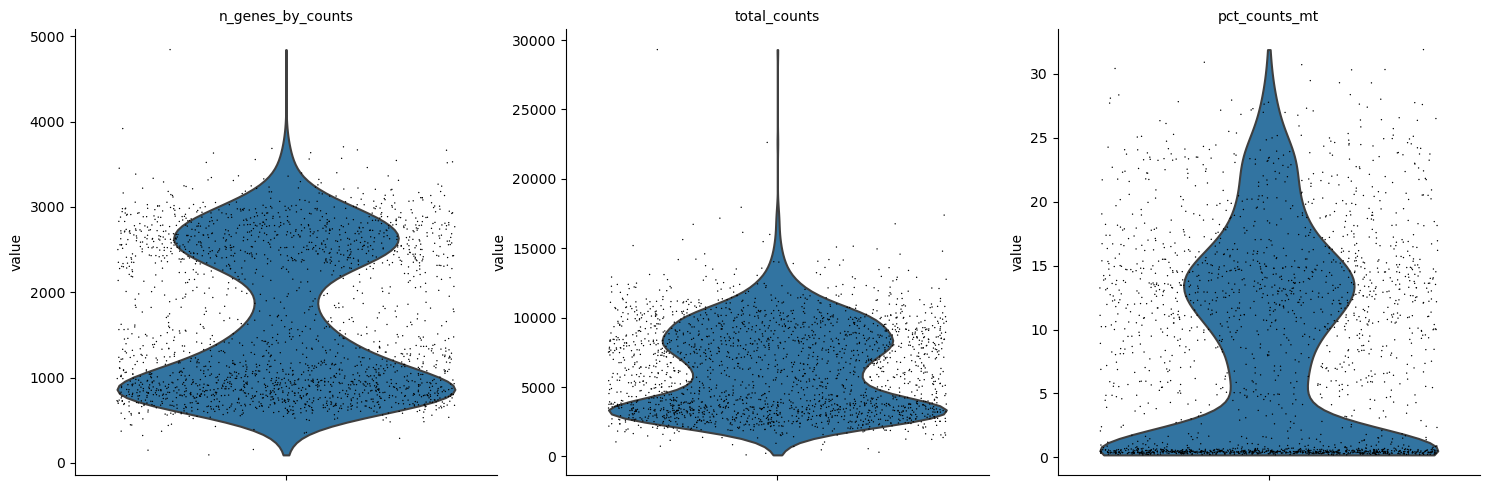

In [1]:
from util import *

h5_path = 'E://human/GSM4838132_Visium_Sample_B_filtered_feature_bc_matrix.h5'
csv_path = 'E://human/GSM4838132_Visium_Sample_B_tissue_positions_list.csv'

h5_path = 'E://human/GSM4838131_Visium_Sample_A_filtered_feature_bc_matrix.h5'
csv_path = 'E://human/GSM4838131_Visium_Sample_A_tissue_positions_list.csv'

h5_path = 'E://human/GSM4838133_Visium_Sample_C_filtered_feature_bc_matrix.h5'
csv_path = 'E://human/GSM4838133_Visium_Sample_C_tissue_positions_list.csv'

h5_path = '/Users/sunpeisen/Downloads/data/GSM4838132_Visium_Sample_B_filtered_feature_bc_matrix.h5'
csv_path = '/Users/sunpeisen/Downloads/data/GSM4838132_Visium_Sample_B_tissue_positions_list.csv'

adata = sc.read_10x_h5(h5_path)
add_spatial_position(adata, csv_path)
adata.var_names_make_unique()
sc.pp.calculate_qc_metrics(adata, inplace=True)

#sc.pp.filter_genes(adata, min_cells=2)
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata.var_names_make_unique()

#adata = adata[adata.obs["pct_counts_mt"] < 8]

sc.pl.violin(adata, 
             ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)


In [2]:
sc.pp.filter_genes(adata, min_cells=20)
adata

AnnData object with n_obs × n_vars = 2179 × 11470
    obs: 'x', 'y', 'fig_x', 'fig_y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt', 'n_cells'
    obsm: 'spatial'

In [240]:
result = convolve(get_3D_matrix(adata), kernel=get_gaussian_kernel(size=5))
update_anndata(result, adata)

Transfer anndate to 3D matrix...


100%|████████████████████| 2179/2179 [00:05<00:00, 430.38it/s]100%


Convolve each 2D layer...


100%|████████████████████| 11470/11470 [00:23<00:00, 493.75it/s]100%


Update anndata...


  0%|                    | 0/2179 [00:00<?, ?it/s]  0%/Users/sunpeisen/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
100%|████████████████████| 2179/2179 [05:12<00:00,  6.97it/s]100%


In [66]:
sc.pp.log1p(adata)

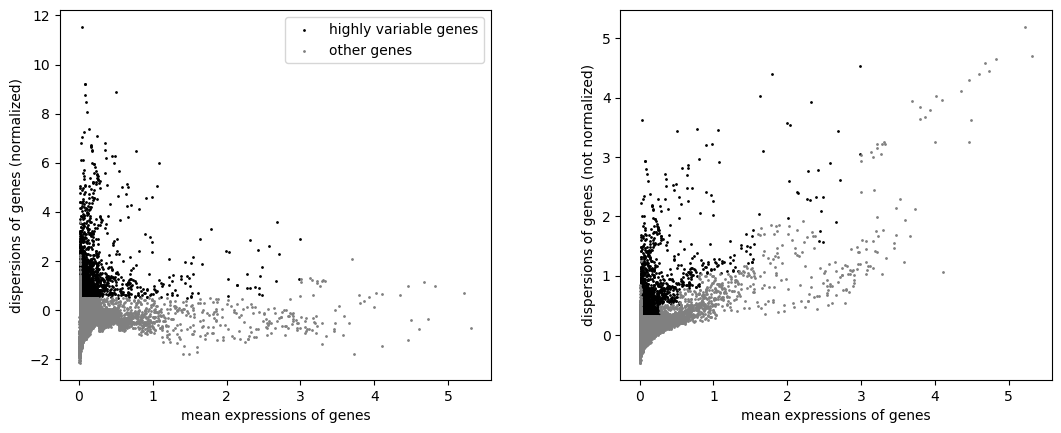

In [4]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [ ]:
# TODO: know why
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

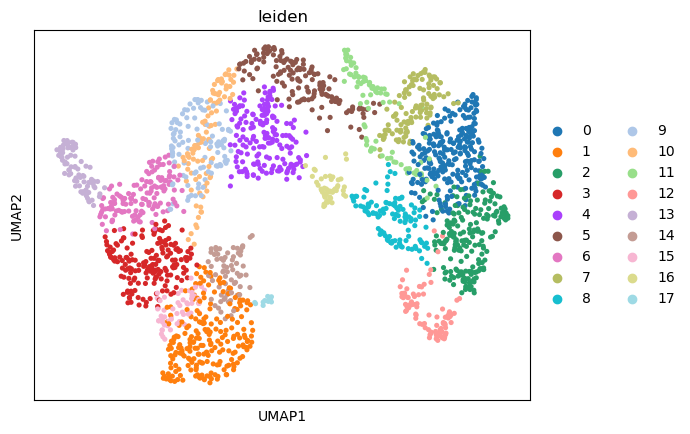

In [32]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=50)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color='leiden')

In [33]:
sq.pl.spatial_scatter(adata, color='leiden', shape=None, dpi=200, size=24)

In [16]:
tmp = adata[(adata.obs['leiden']=='3') |
            (adata.obs['leiden']=='0')]

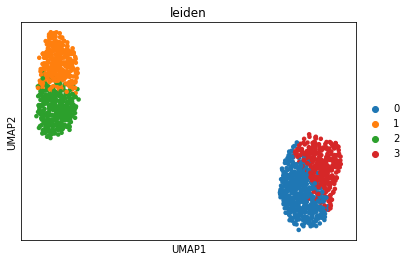

In [26]:
tmp.uns.pop('leiden_colors')
sc.tl.pca(tmp, svd_solver='arpack')
sc.pp.neighbors(tmp, n_neighbors=20, n_pcs=50)
sc.tl.umap(tmp)
sc.tl.leiden(tmp)
sc.pl.umap(tmp, color='leiden')

In [17]:
sq.pl.spatial_scatter(tmp, color='leiden', shape=None, dpi=200, size=24)

/Users/sunpeisen/opt/anaconda3/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


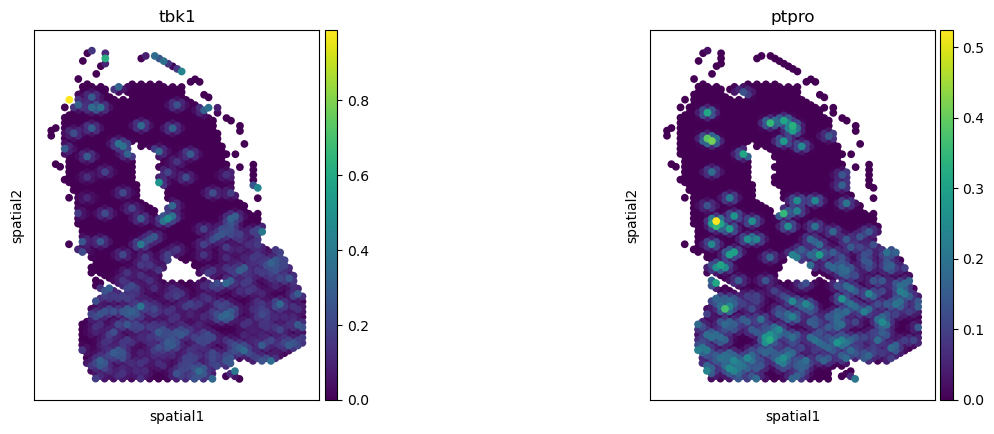

In [35]:
sc.pl.spatial(adata, 
              size=2,
              spot_size=300,
              color=['tbk1','ptpro'])

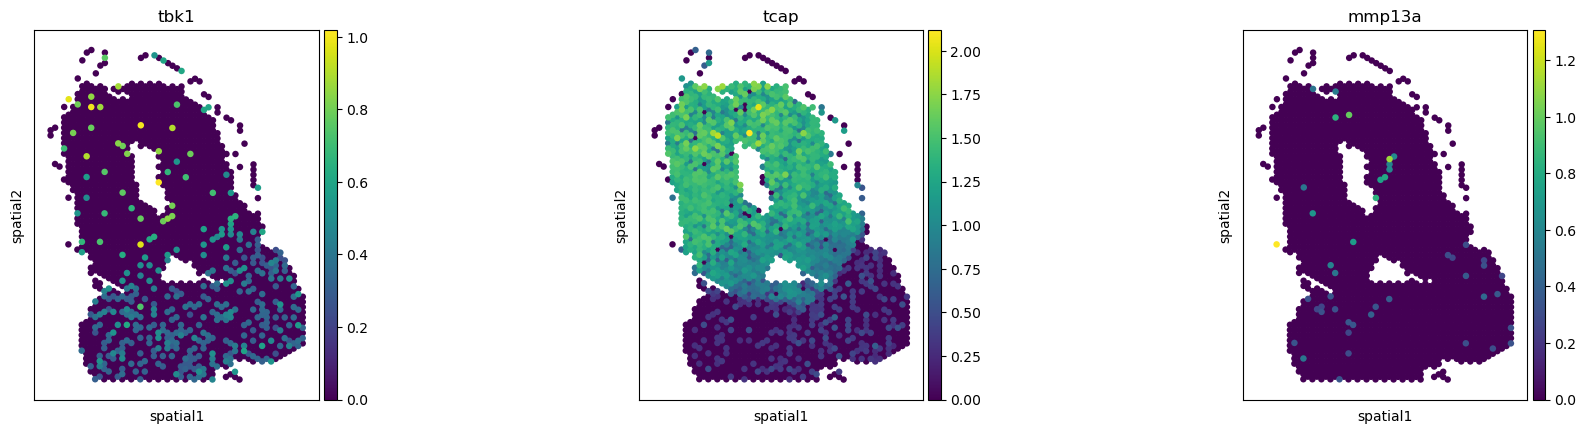

In [80]:
sc.pl.spatial(adata, 
              size=2,
              spot_size=250,
              color=['tbk1','tcap','mmp13a'])

In [347]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal
from sklearn import mixture

sample = []
t = adata[:, adata.var_names == 'ptpro']
for index, value in enumerate(t.X.todense()):
    tmp = int(value*10)
    if tmp > 0:
        for i in range(tmp):
            sample.append([int(t[index].obs.fig_x), int(t[index].obs.fig_y)])

gmm1 = mixture.GaussianMixture(n_components=5, max_iter=2000, warm_start=False)
gmm1.fit(sample)

GaussianMixture(max_iter=2000, n_components=5)

In [341]:
sample = []
t = adata[:, adata.var_names == 'tcap']
for index, value in enumerate(t.X.todense()):
    tmp = int(value*10)
    if tmp > 0:
        for i in range(tmp):
            sample.append([int(t[index].obs.fig_x), int(t[index].obs.fig_y)])

gmm = mixture.GaussianMixture(n_components=5, max_iter=2000, warm_start=False)
gmm.fit(sample)

GaussianMixture(max_iter=2000, n_components=5)

In [348]:
import numpy as np
from scipy.stats import multivariate_normal

# 定义两个GMM
gmm1_weights = gmm1.weights_
gmm1_means = gmm1.means_
gmm1_covs = gmm1.covariances_

gmm2_weights = gmm.weights_
gmm2_means = gmm.means_
gmm2_covs = gmm.covariances_
n_components = gmm2_weights.size
# 计算所有组件之间的Bhattacharyya距离
bhat_dist = np.zeros((n_components, n_components))
for i in range(n_components):
    for j in range(n_components):
        bhat_dist[i, j] = 0.25 * (np.log(np.linalg.det(0.5*(gmm1_covs[i]+gmm2_covs[j]))) 
                                  - 0.5*np.log(np.linalg.det(gmm1_covs[i])) 
                                  - 0.5*np.log(np.linalg.det(gmm2_covs[j]))
                                  + 0.5*((gmm1_means[i] - gmm2_means[j]).T @ np.linalg.inv(0.5*(gmm1_covs[i]+gmm2_covs[j]))
                                         @ (gmm1_means[i] - gmm2_means[j]))
                                  + 0.125*np.trace(np.linalg.inv(0.5*(gmm1_covs[i]+gmm2_covs[j])) @ gmm1_covs[i])
                                  + 0.125*np.trace(np.linalg.inv(0.5*(gmm1_covs[i]+gmm2_covs[j])) @ gmm2_covs[j])
                                 )
min_bhat_dist = np.min(bhat_dist)
min_bd = bhat_dist * gmm1_weights.reshape(n_components, 1)
print("Bhattacharyya距离的最小值为：", np.sum(np.amin(min_bd, axis=1)))

Bhattacharyya距离的最小值为： 0.7116022105043794


In [294]:
np.sum(np.amin(min_bd, axis=1))

0.43505009813890055

In [285]:
min_bd

array([[2.4451762 , 0.37824451, 0.05208514, 1.23455037, 1.27124738],
       [0.57950696, 0.13356634, 0.35548324, 0.1101577 , 0.52815172],
       [1.89706858, 0.33182171, 0.11722155, 0.54381315, 1.5077447 ],
       [0.10247967, 0.08141046, 0.36812982, 0.09335388, 0.08758567],
       [0.84332101, 0.07417525, 0.28439346, 0.90722453, 0.3436374 ]])

In [291]:
gmm1_means

array([[ 8906.54862364, 10066.57246065],
       [17100.67611242, 16397.15996533],
       [15034.23729897,  9964.24334304],
       [15675.1765507 , 21433.26170276],
       [ 9868.16677031, 16956.72089598]])

In [292]:
gmm2_means

array([[18767.64907654, 25949.04719661],
       [12339.37525267, 17321.57645553],
       [10659.08739606,  9084.00703966],
       [20329.62314759, 19905.44734482],
       [11825.54445339, 24884.36615121]])

In [273]:
np.array([[1,1],[2,2]]) * np.array([1,2]).reshape(2,1)

array([[1, 1],
       [4, 4]])

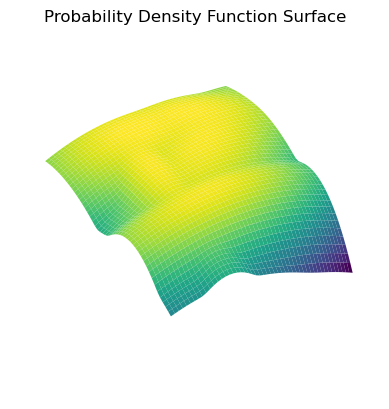

In [218]:
# 网格化数据空间
x = np.linspace(0, 30000, 50)
y = np.linspace(0, 30000, 50)
X, Y = np.meshgrid(x, y)
XY = np.column_stack([X.flat, Y.flat])

# 计算概率密度函数值
Z = gmm1.score_samples(XY)
Z = Z.reshape(X.shape)
# 绘制三维表面图
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('pdf')
ax.set_box_aspect([2, 2, 1])
ax.set_title('Probability Density Function Surface')
ax.grid(False)
ax.axis('off')
ax.view_init(elev=40, azim=235)
plt.show()

In [217]:
import numpy as np
from numpy.linalg import inv
from scipy.linalg import det
from scipy.spatial.distance import mahalanobis

mu1 = gmm.means_
cov1 = gmm.covariances_
w1 = gmm.weights_
mu2 = gmm1.means_
cov2 = gmm1.covariances_
w2 = gmm1.weights_

# 计算Bhattacharyya距离
cov = (cov1.mean(axis=0) + cov2.mean(axis=0)) / 2
diff_transpose_cov = (mu1.mean(axis=0) - mu2.mean(axis=0)).T.dot(np.linalg.inv(cov))
sqrt_bc = np.sqrt((w1 * w2).sum()) * np.exp(-1/8 * diff_transpose_cov.dot(mu1.mean(axis=0) - mu2.mean(axis=0)))
bd = -np.log(sqrt_bc)

print("Bhattacharyya distance:", bd)

Bhattacharyya distance: 0.8070028611620356


In [ ]:
import seaborn as sns
total_list = []

for i in mean_list[:500]:
    for j in i:
        total_list.append(list(j))

df = pd.DataFrame(total_list,columns=['x','y'])

In [94]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
kmeans.fit(total_list)
df['label'] = kmeans.labels_

<AxesSubplot:xlabel='x', ylabel='y'>

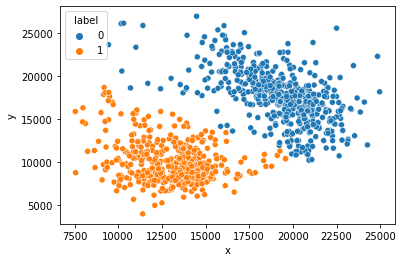

In [95]:
sns.scatterplot(data=df, x='x',y='y',hue='label')

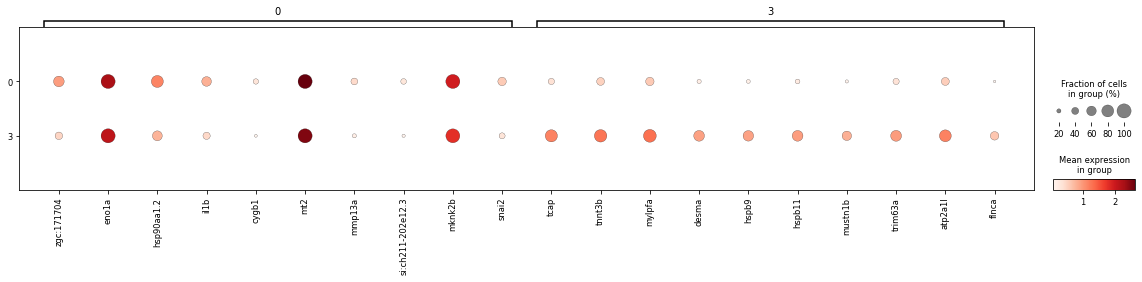

In [295]:
sc.tl.rank_genes_groups(tmp, groupby="leiden")
import matplotlib.pyplot as plt

sc.pl.rank_genes_groups_dotplot(tmp, 
                                groupby="leiden", 
                                figsize=(20,3)
                                )

f:\conda\lib\site-packages\scanpy\plotting\_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


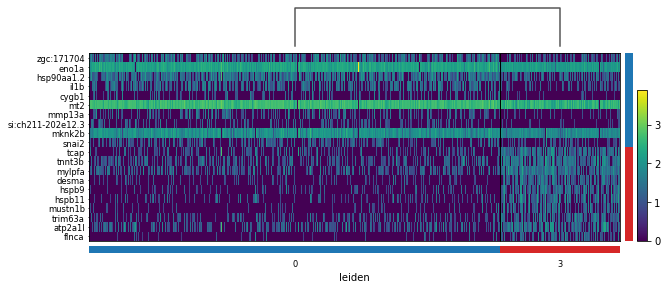

In [226]:
sc.pl.rank_genes_groups_heatmap(tmp, 
                                swap_axes=True,
                                groupby="leiden")

f:\conda\lib\site-packages\scanpy\plotting\_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


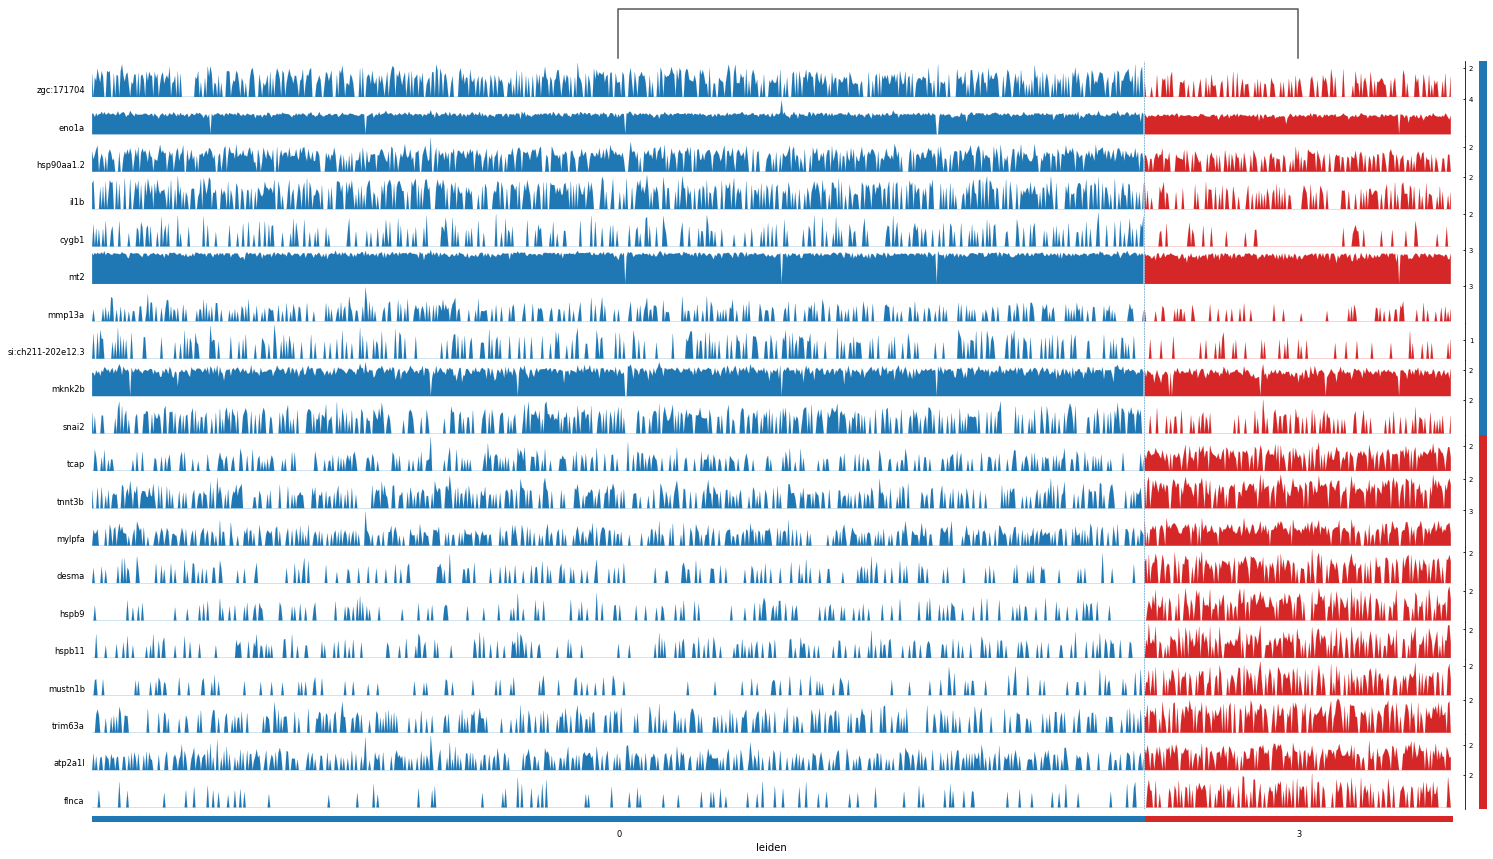

In [228]:
sc.pl.rank_genes_groups_tracksplot(tmp, figsize=(25,15))

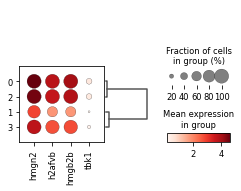

In [143]:
all_genes = ['hmgn2','h2afvb','hmgb2b','tbk1']
sc.pl.dotplot(tmp, 
              var_names=all_genes, 
              groupby='leiden', 
              dendrogram=True)

f:\conda\lib\site-packages\scanpy\plotting\_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


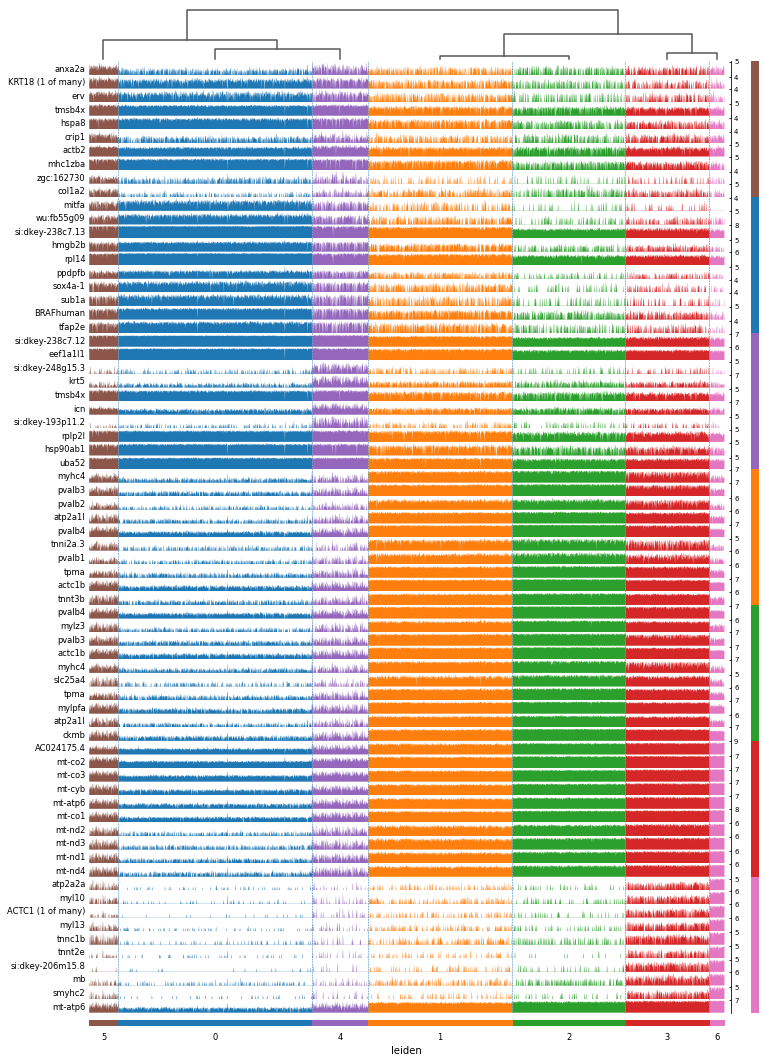

In [107]:
sc.tl.rank_genes_groups(adata, groupby="leiden")
sc.pl.rank_genes_groups_tracksplot(adata)